# Tract-Patch Search

In [1]:
from dask.distributed import Client
import lsdb
import skymap_convert
from lsdb_rubin import tract_patch_search

In [2]:
client = Client(n_workers=4, memory_limit="auto")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 20,Total memory: 31.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46255,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.00 GiB
Comm: tcp://127.0.0.1:46733,Total threads: 5
Dashboard: http://127.0.0.1:33967/status,Memory: 7.75 GiB
Nanny: tcp://127.0.0.1:32773,


## Load GAIA and the LSST skymap

The catalog starts with 2,000+ partitions, and we can see the distribution of those partitions on the sky with the below plot. The yellow areas are the galactic bulge, where there is higher angular density of objects, and so we use smaller data partitions in the HATS catalog.

In [3]:
# Load GAIA DR3 data.

gaia = lsdb.open_catalog("https://data.lsdb.io/hats/gaia_dr3", columns=["ra", "dec", "source_id"])
gaia

,ra,dec,source_id
npartitions=2016,,,
"Order: 2, Pixel: 0",double[pyarrow],double[pyarrow],int64[pyarrow]
"Order: 2, Pixel: 1",...,...,...
...,...,...,...
"Order: 3, Pixel: 766",...,...,...
"Order: 3, Pixel: 767",...,...,...


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - gaia'}>)

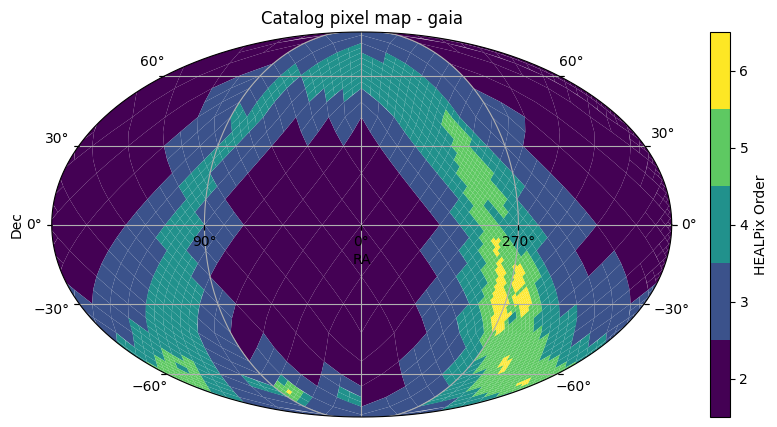

In [4]:
gaia.plot_pixels()

In [5]:
# Load the LSST skymap.

import skymap_convert

lsst_skymap = skymap_convert.ConvertedSkymapReader(preset="lsst_skymap")

## Search by tract ID

We search by a tract in the galactic bulge, and see that it overlaps with a few of the partitions in that region.

We can attach a new method called `tract_patch_search`, which is implemented to supplement other types of region search on the `lsdb` `Catalog` object.  You can find more general information on region search in [the LSDB documentation](https://docs.lsdb.io/en/latest/tutorials/region_selection.html).

In [6]:
from lsdb.core.plotting import plot_points
import astropy.units as u
from astropy.coordinates import SkyCoord

fov = (5 * u.deg, 5 * u.deg)
center = SkyCoord(265 * u.deg, -30 * u.deg)

tract_index = 4975
patch_index = 67

In [7]:
# Only specify the tract (and not patch) to search by tract.

lsdb.catalog.Catalog.tract_patch_search = tract_patch_search

gaia_tract = gaia.tract_patch_search(skymap_reader=lsst_skymap, tract=tract_index)
gaia_tract

,ra,dec,source_id
npartitions=5,,,
"Order: 5, Pixel: 7206",double[pyarrow],double[pyarrow],int64[pyarrow]
"Order: 5, Pixel: 7207",...,...,...
"Order: 6, Pixel: 28848",...,...,...
"Order: 6, Pixel: 28849",...,...,...
"Order: 6, Pixel: 28852",...,...,...


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Gaia DR3 Tract Search'}>)

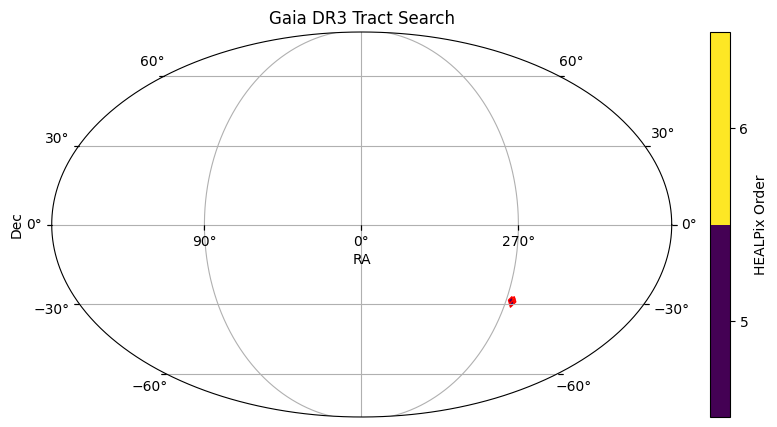

In [8]:
gaia_tract.plot_pixels(
    plot_title="Gaia DR3 Tract Search",
    fc="#00000000",
    ec="red",
)

### Plot the points within our tract search

In [9]:
df = gaia_tract.compute()
df

/home/delucchi/.virtualenvs/sep/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 116.79 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,ra,dec,source_id
_healpix_29,,,
2028429617617798730,266.228612,-29.751009,4056859222565665024
2028429623682899072,266.214002,-29.750143,4056859222553709184
...,...,...,...
2030314331564457470,265.403714,-28.265501,4060628657676158080
2030314331687825753,265.40231,-28.265104,4060628661956658816


Zooming in on the tract, we can see the ~400,000 points from the catalog, in a semi-rectangular "tract-shaped" region

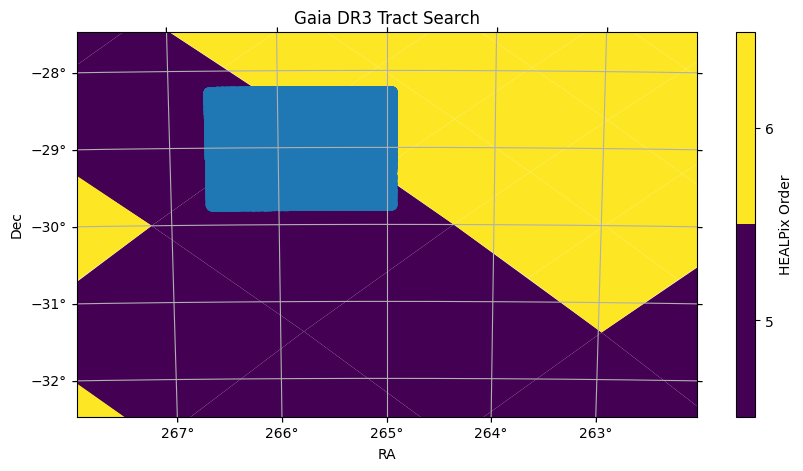

In [10]:
fig, ax = gaia.plot_pixels(projection="AIT", fov=fov, center=center)
_ = plot_points.plot_points(
    df,
    ra_column="ra",
    dec_column="dec",
    title="Gaia DR3 Tract Search",
    fov=fov,
    center=center,
)

## Search by patch ID

In [11]:
# Specify both tract and patch to search by tract and patch.

gaia_tract_patch = gaia.tract_patch_search(
    skymap_reader=lsst_skymap,
    tract=tract_index,
    patch=patch_index,  # include patch here!
)
gaia_tract_patch

,ra,dec,source_id
npartitions=1,,,
"Order: 6, Pixel: 28849",double[pyarrow],double[pyarrow],int64[pyarrow]


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Gaia DR3 Tract and Patch Search'}>)

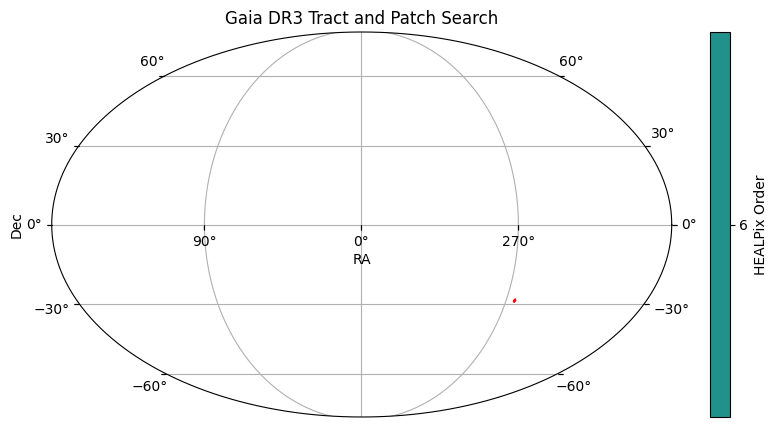

In [12]:
gaia_tract_patch.plot_pixels(
    plot_title="Gaia DR3 Tract and Patch Search",
    fc="#00000000",
    ec="red",
)

### Plot the points within our patch search

In [13]:
df = gaia_tract_patch.compute()
df

/home/delucchi/.virtualenvs/sep/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 116.78 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,ra,dec,source_id
_healpix_29,,,
2030076515776642061,265.294515,-28.840948,4060153015792358784
2030076516438355910,265.292557,-28.839182,4060153015802849152
...,...,...,...
2030095571649978731,265.299339,-28.674579,4060191125115382656
2030095571700128422,265.299429,-28.673891,4060191125095778944


Zooming in to the same sky area as above, we see only the ~10,000 points that are in the semi-rectangular patch region.

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Gaia DR3 Tract and Patch Search'}>)

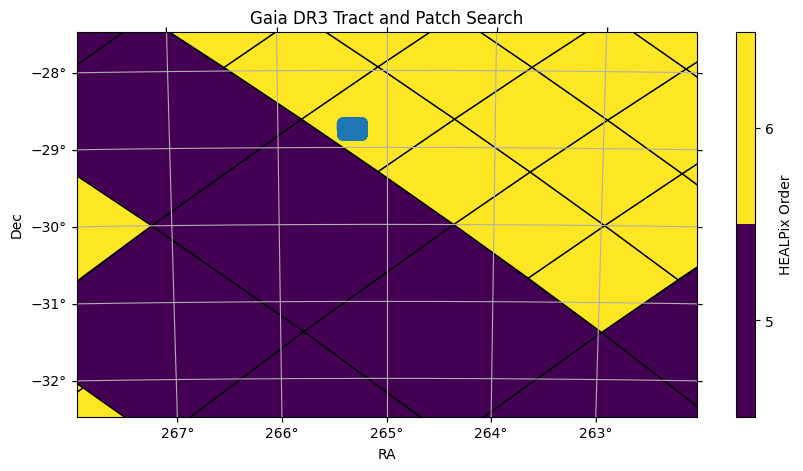

In [14]:
fig, ax = gaia.plot_pixels(projection="AIT", fov=fov, center=center, ec="000000")
plot_points.plot_points(
    df,
    ra_column="ra",
    dec_column="dec",
    title="Gaia DR3 Tract and Patch Search",
    fov=fov,
    center=center,
)

## About

**Authors**: Olivia Lynn

**Last updated on**: October 8, 2025

If you use ``lsdb`` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).